In [952]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandera.pandas as pa
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA



pd.set_option('display.float_format', '{:.2f}'.format)

<h2 style="text-align: center">DATA LOADING</h2>

In [953]:
DATA_PATH = "../data/online_retail_II.xlsx"

df = pd.read_excel(DATA_PATH, sheet_name=0, dtype={"Customer ID": str})

In [954]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085,United Kingdom


In [955]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[us]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  str           
 7   Country      525461 non-null  str           
dtypes: datetime64[us](1), float64(1), int64(1), object(3), str(2)
memory usage: 32.1+ MB


In [956]:
df.describe()

,Quantity,InvoiceDate,Price
count,525461.00,525461,525461.00
mean,10.34,2010-06-28 11:37:36.845018,4.69
min,-9600.00,2009-12-01 07:45:00,-53594.36
25%,1.00,2010-03-21 12:20:00,1.25
50%,3.00,2010-07-06 09:51:00,2.10
75%,10.00,2010-10-15 12:45:00,4.21
max,19152.00,2010-12-09 20:01:00,25111.09
std,107.42,NaN,146.13


In [957]:
df.describe(include=['object', 'str'])

,Invoice,StockCode,Description,Customer ID,Country
count,525461,525461,522533,417534,525461
unique,28816,4632,4681,4383,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,14911,United Kingdom
freq,675,3516,3549,5710,485852


In [958]:
# schema validation before data cleaning (so nulls are allowed)


schema_raw = pa.DataFrameSchema({
    "Customer ID": pa.Column(str, nullable=True),
    "Invoice": pa.Column(object, nullable=True),
    "Quantity": pa.Column(int, nullable=True),
    "Price": pa.Column(float, nullable=True),
    "InvoiceDate": pa.Column("datetime64[us]", nullable=True),
    "Country": pa.Column(str, nullable=True),
    # "Description", "StockCode" - ignore because they are object types
})
schema_raw.validate(df)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom


<h2 style="text-align: center">DATA CLEANING</h2>

In [959]:
df[df["Customer ID"].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


In [960]:
df[df["Quantity"] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592,United Kingdom


In [961]:
df[df["Price"] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [962]:
df["Invoice"] = df["Invoice"].astype("str")

df[df["Invoice"].str.match("^\\d{6}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329,United Kingdom


In [963]:
df["Invoice"].str.replace("[0-9]", "", regex=True).unique()

# unique Invoice prefixes values

<StringArray>
['', 'C', 'A']
Length: 3, dtype: str

In [964]:
df[df["Invoice"].str.startswith("A", na = False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [965]:
df["StockCode"] = df["StockCode"].astype("str")

df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

# this regex is for StockCode values that are not 5 digits or 5 digits followed by letters, which are the valid formats for StockCode. 
# So it reveals all the anomalous/non-standard stock codes

<StringArray>
[        'POST',            'D',     'DCGS0058',     'DCGS0068',
          'DOT',            'M',     'DCGS0004',     'DCGS0076',
           'C2', 'BANK CHARGES',     'DCGS0003',      'TEST001',
 'gift_0001_80',     'DCGS0072', 'gift_0001_20',     'DCGS0044',
      'TEST002', 'gift_0001_10', 'gift_0001_50',    'DCGS0066N',
 'gift_0001_30',         'PADS',       'ADJUST', 'gift_0001_40',
 'gift_0001_60', 'gift_0001_70', 'gift_0001_90',    'DCGSSGIRL',
     'DCGS0006',     'DCGS0016',     'DCGS0027',     'DCGS0036',
     'DCGS0039',     'DCGS0060',     'DCGS0056',     'DCGS0059',
         'GIFT',     'DCGSLBOY',            'm',     'DCGS0053',
     'DCGS0062',     'DCGS0037',     'DCGSSBOY',    'DCGSLGIRL',
            'S',     'DCGS0069',     'DCGS0070',     'DCGS0075',
            'B',     'DCGS0041',      'ADJUST2',      '47503J ',
           'C3',       'SP1002',    'AMAZONFEE']
Length: 55, dtype: str

In [966]:
df[df["StockCode"].str.contains("^DOT")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2379,489597,DOT,DOTCOM POSTAGE,1,2009-12-01 14:28:00,647.19,NaN,United Kingdom
2539,489600,DOT,DOTCOM POSTAGE,1,2009-12-01 14:43:00,55.96,NaN,United Kingdom
2551,489601,DOT,DOTCOM POSTAGE,1,2009-12-01 14:44:00,68.39,NaN,United Kingdom
2571,489602,DOT,DOTCOM POSTAGE,1,2009-12-01 14:45:00,59.35,NaN,United Kingdom
2619,489603,DOT,DOTCOM POSTAGE,1,2009-12-01 14:46:00,42.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524272,538071,DOT,DOTCOM POSTAGE,1,2010-12-09 14:09:00,885.94,NaN,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


In [967]:
cleaned_df = df.copy()

In [968]:
# Actual cleaning starts:

cleaned_df["Invoice"] = cleaned_df["Invoice"].astype("str")

# filtering expression:
mask = (
    cleaned_df["Invoice"].str.match("^\\d{6}$") == True
)

cleaned_df = cleaned_df[mask]

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom


In [969]:
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")

mask = (
    (cleaned_df["StockCode"].str.match("^\\d{5}$") == True)
    | (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)
    | (cleaned_df["StockCode"].str.match("^PADS$") == True)

)

cleaned_df = cleaned_df[mask]

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom


In [970]:
cleaned_df.dropna(subset=["Customer ID"], inplace=True)

In [971]:
cleaned_df.dropna(subset=["InvoiceDate"], inplace=True)

In [972]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price
count,406337.00,406337,406337.00
mean,13.62,2010-07-01 10:11:06.543287,2.99
min,1.00,2009-12-01 07:45:00,0.00
25%,2.00,2010-03-26 14:01:00,1.25
50%,5.00,2010-07-09 15:48:00,1.95
75%,12.00,2010-10-14 17:09:00,3.75
max,19152.00,2010-12-09 20:01:00,295.00
std,97.00,NaN,4.29


In [973]:
len(cleaned_df[cleaned_df["Price"] == 0])

28

In [974]:
cleaned_df = cleaned_df[cleaned_df["Price"] > 0]

In [975]:
cleaned_df = cleaned_df[cleaned_df["Quantity"] > 0]

In [976]:
cleaned_df.drop_duplicates(inplace=True)

In [977]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price
count,399566.00,399566,399566.00
mean,13.80,2010-07-01 04:58:19.365311,3.00
min,1.00,2009-12-01 07:45:00,0.00
25%,2.00,2010-03-26 13:42:00,1.25
50%,5.00,2010-07-09 10:26:00,1.95
75%,12.00,2010-10-14 14:08:00,3.75
max,19152.00,2010-12-09 20:01:00,295.00
std,97.80,NaN,4.31


In [978]:
cleaned_df["Price"].min()

np.float64(0.001)

In [979]:
# Schema validation after cleaning (so nulls are not allowed)

schema_cleaned = pa.DataFrameSchema({
    "Customer ID": pa.Column(str, nullable=False),
    "Invoice": pa.Column(str, nullable=False),
    "Quantity": pa.Column(int, pa.Check.greater_than(0), nullable=False),
    "Price": pa.Column(float, pa.Check.greater_than(0), nullable=False),
    "Description": pa.Column(object, nullable=False),
    "StockCode": pa.Column(str, nullable=False),
    "InvoiceDate": pa.Column("datetime64[us]", nullable=False),
    "Country": pa.Column(str, nullable=False),
})
schema_cleaned.validate(cleaned_df)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom


In [980]:
len(cleaned_df)/len(df)

0.7604103825022218

Finals result: Dropped about 24% of the records

<h2 style="text-align: center">FEATURE ENGINEERING</h2>

Features: Recency, Frequency, Monetary, Tenure, AOV

In [981]:
cleaned_df["SalesLineTotal"] = cleaned_df["Quantity"] * cleaned_df["Price"] # total revenue for each individual transaction row.

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SalesLineTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530,United Kingdom,7.50


In [982]:
aggregated_df = cleaned_df.groupby(by="Customer ID", as_index=False) \
    .agg(
        MonetaryValue=("SalesLineTotal", "sum"),
        Frequency=("Invoice", "nunique"),
        LastInvoiceDate=("InvoiceDate", "max"),
        FirstInvoiceDate=("InvoiceDate", "min")
    )

aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,FirstInvoiceDate
0,12346,169.36,2,2010-06-28 13:53:00,2010-03-02 13:08:00
1,12347,1323.32,2,2010-12-07 14:57:00,2010-10-31 14:20:00
2,12348,221.16,1,2010-09-27 14:59:00,2010-09-27 14:59:00
3,12349,2221.14,2,2010-10-28 08:23:00,2010-04-29 13:20:00
4,12351,300.93,1,2010-11-29 15:23:00,2010-11-29 15:23:00


In [983]:
max_invoice_data = aggregated_df["LastInvoiceDate"].max()

aggregated_df["Recency"] = (max_invoice_data - aggregated_df["LastInvoiceDate"]).dt.days
aggregated_df["Tenure"] = (aggregated_df["LastInvoiceDate"] - aggregated_df["FirstInvoiceDate"]).dt.days
aggregated_df["AOV"] = aggregated_df["MonetaryValue"] / aggregated_df["Frequency"]
aggregated_df.drop(columns=["LastInvoiceDate", "FirstInvoiceDate"], inplace=True)

aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,Recency,Tenure,AOV
0,12346,169.36,2,164,118,84.68
1,12347,1323.32,2,2,37,661.66
2,12348,221.16,1,73,0,221.16
3,12349,2221.14,2,42,181,1110.57
4,12351,300.93,1,10,0,300.93


In [984]:
aggregated_df["MonetaryValue"] = np.log1p(aggregated_df["MonetaryValue"])
aggregated_df["Frequency"] = np.log1p(aggregated_df["Frequency"])
aggregated_df["Recency"] = np.log1p(aggregated_df["Recency"])
aggregated_df["Tenure"] = np.log1p(aggregated_df["Tenure"])
aggregated_df["AOV"] = np.log1p(aggregated_df["AOV"])

VISUALIZATION - MATPLOTLIB

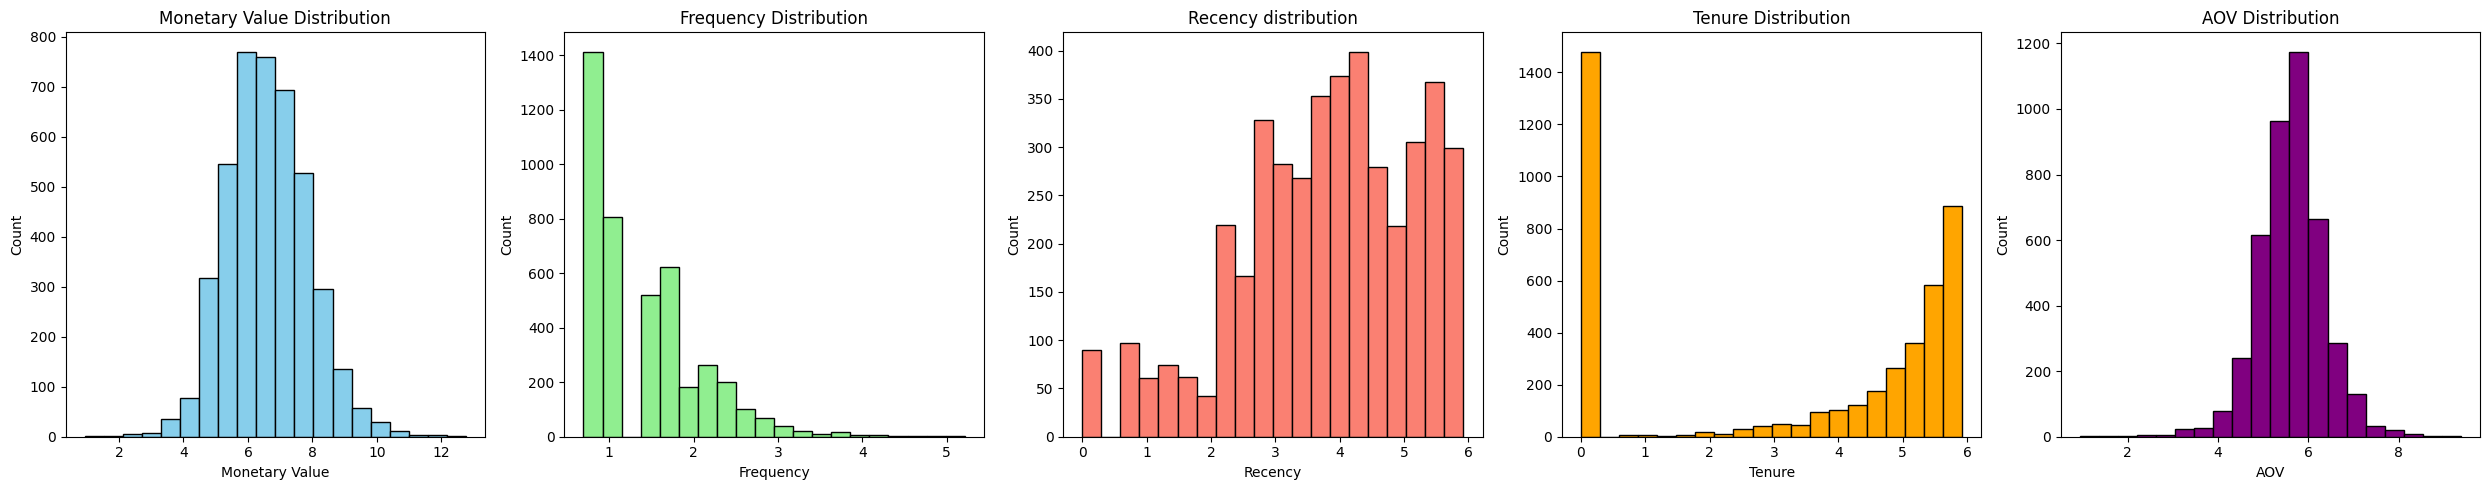

In [985]:
# shape/skewness visualization
plt.figure(figsize=(25, 5))

plt.subplot(1, 5, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=20, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 5, 2)
plt.hist(aggregated_df['Frequency'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 5, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.subplot(1, 5, 4)
plt.hist(aggregated_df['Tenure'], bins=20, color='orange', edgecolor='black')
plt.title('Tenure Distribution')
plt.xlabel('Tenure')
plt.ylabel('Count')

plt.subplot(1, 5, 5)
plt.hist(aggregated_df['AOV'], bins=20, color='purple', edgecolor='black')
plt.title('AOV Distribution')
plt.xlabel('AOV')
plt.ylabel('Count')


plt.tight_layout()
plt.show()

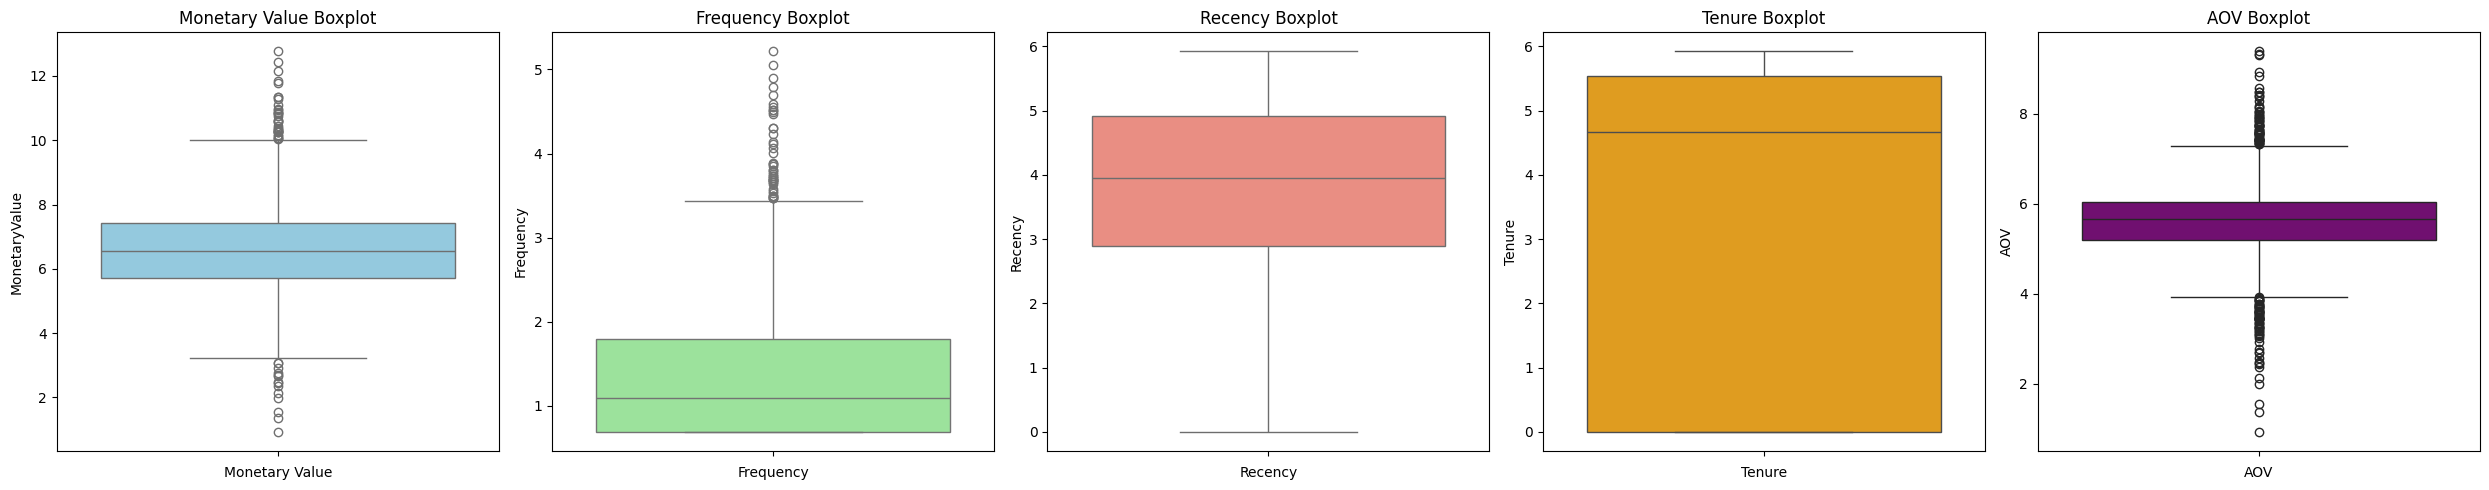

In [986]:
# outlier visualization
plt.figure(figsize=(25, 5))

plt.subplot(1, 5, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 5, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 5, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.subplot(1, 5, 4)
sns.boxplot(data=aggregated_df['Tenure'], color='orange')
plt.title('Tenure Boxplot')
plt.xlabel('Tenure')

plt.subplot(1, 5, 5)
sns.boxplot(data=aggregated_df['AOV'], color='purple')
plt.title('AOV Boxplot')
plt.xlabel('AOV')

plt.tight_layout()
plt.show()


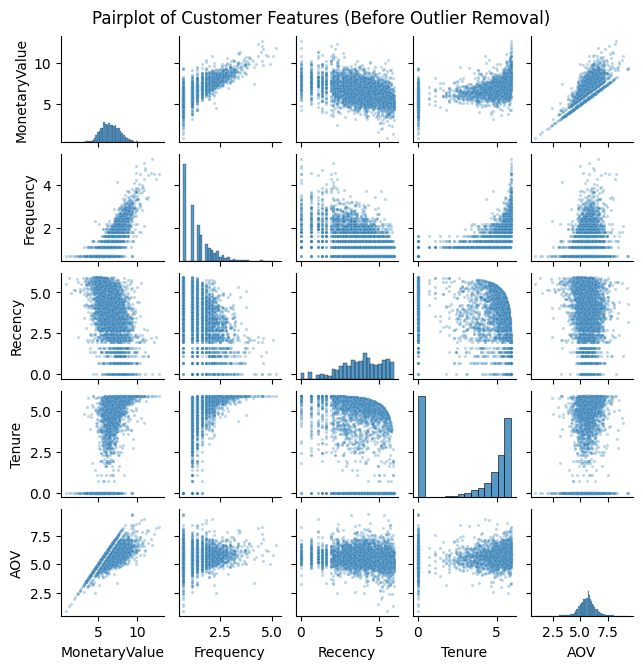

In [987]:
# more detailed visualization before outlier removal

sns.pairplot(aggregated_df[["MonetaryValue", "Frequency", "Recency", "Tenure", "AOV"]], 
             plot_kws={"alpha": 0.3, "s": 5},
             height=1.3)
plt.suptitle("Pairplot of Customer Features (Before Outlier Removal)", y=1.02)
plt.show()

<h2 style="text-align: center">OUTLIER DETECTION</h2>

In [988]:
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1


monetary_outliers_df = aggregated_df[(aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))].copy()

monetary_outliers_df.describe()




,MonetaryValue,Frequency,Recency,Tenure,AOV
count,48.00,48.00,48.00,48.00,48.00
mean,8.34,2.84,2.79,4.10,5.73
std,3.96,1.56,1.90,2.67,2.34
min,0.94,0.69,0.00,0.00,0.94
25%,3.03,0.69,1.55,0.00,3.03
50%,10.31,3.33,2.20,5.88,6.61
75%,10.85,4.02,5.04,5.90,7.27
max,12.76,5.21,5.92,5.92,8.92


In [989]:
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1


frequency_outliers_df = aggregated_df[(aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) 
                                      | (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()

frequency_outliers_df.describe()



,MonetaryValue,Frequency,Recency,Tenure,AOV
count,46.00,46.00,46.00,46.00,46.00
mean,10.18,4.00,1.52,5.86,6.21
std,1.04,0.47,1.20,0.18,0.88
min,7.44,3.47,0.00,4.75,3.35
25%,9.60,3.67,0.69,5.89,5.79
50%,9.91,3.81,1.50,5.91,6.19
75%,10.81,4.30,2.08,5.91,6.63
max,12.76,5.21,5.11,5.92,8.27


In [990]:
R_Q1 = aggregated_df['Recency'].quantile(0.25)
R_Q3 = aggregated_df['Recency'].quantile(0.75)
R_IQR = R_Q3 - R_Q1

recency_outliers_df = aggregated_df[(aggregated_df['Recency'] > (R_Q3 + 1.5 * R_IQR)) 
                                | (aggregated_df['Recency'] < (R_Q1 - 1.5 * R_IQR))].copy()


In [991]:
A_Q1 = aggregated_df['AOV'].quantile(0.25)
A_Q3 = aggregated_df['AOV'].quantile(0.75)
A_IQR = A_Q3 - A_Q1

aov_outliers_df = aggregated_df[(aggregated_df['AOV'] > (A_Q3 + 1.5 * A_IQR)) 
                                | (aggregated_df['AOV'] < (A_Q1 - 1.5 * A_IQR))].copy()

In [992]:
T_Q1 = aggregated_df['Tenure'].quantile(0.25)
T_Q3 = aggregated_df['Tenure'].quantile(0.75)
T_IQR = T_Q3 - T_Q1

tenure_outliers_df = aggregated_df[(aggregated_df['Tenure'] > (T_Q3 + 1.5 * T_IQR)) 
                                | (aggregated_df['Tenure'] < (T_Q1 - 1.5 * T_IQR))].copy()

In [993]:
non_outliers_df = aggregated_df[
    (~aggregated_df.index.isin(monetary_outliers_df.index)) & 
    (~aggregated_df.index.isin(frequency_outliers_df.index)) &
    (~aggregated_df.index.isin(aov_outliers_df.index))
]
non_outliers_df.describe()

,MonetaryValue,Frequency,Recency,Tenure,AOV
count,4106.00,4106.00,4106.00,4106.00,4106.00
mean,6.58,1.35,3.80,3.33,5.63
std,1.13,0.63,1.37,2.51,0.62
min,3.94,0.69,0.00,0.00,3.93
25%,5.74,0.69,2.94,0.00,5.21
50%,6.52,1.10,3.95,4.69,5.65
75%,7.38,1.79,4.87,5.53,6.02
max,10.00,3.43,5.92,5.92,7.29


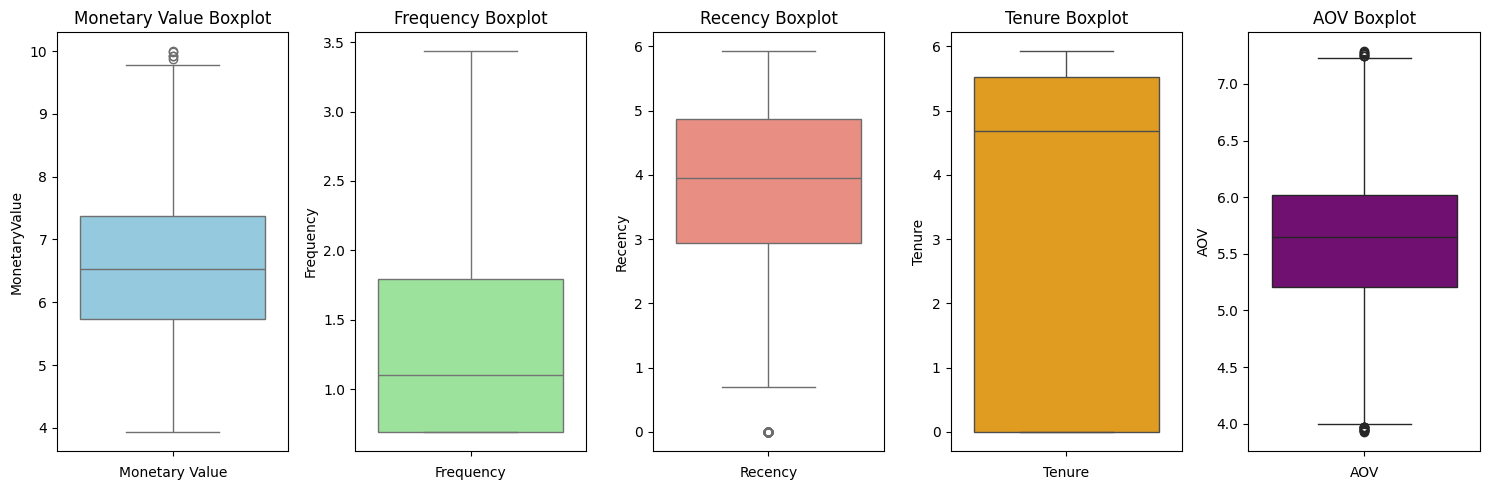

In [994]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
sns.boxplot(data=non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 5, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 5, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.subplot(1, 5, 4)
sns.boxplot(data=non_outliers_df['Tenure'], color='orange')
plt.title('Tenure Boxplot')
plt.xlabel('Tenure')

plt.subplot(1, 5, 5)
sns.boxplot(data=non_outliers_df['AOV'], color='purple')
plt.title('AOV Boxplot')
plt.xlabel('AOV')



plt.tight_layout()
plt.show()

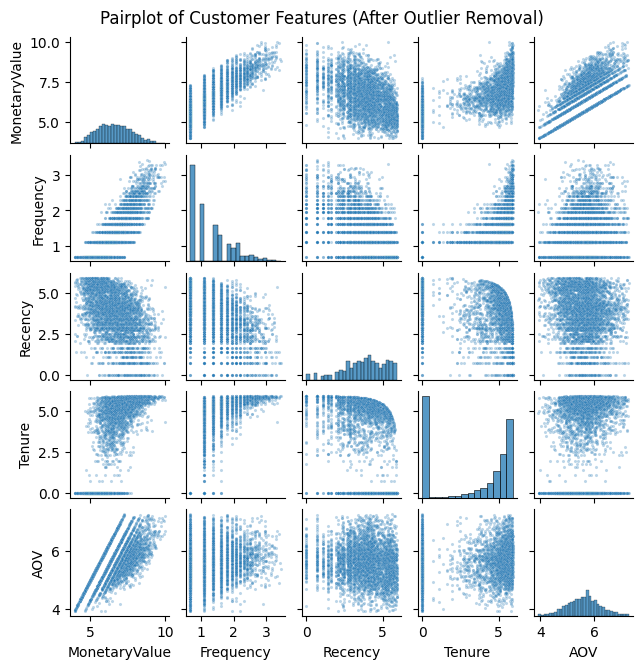

In [995]:
sns.pairplot(non_outliers_df[["MonetaryValue", "Frequency", "Recency", "Tenure", "AOV"]], 
             plot_kws={"alpha": 0.3, "s": 5},
             height=1.3)
plt.suptitle("Pairplot of Customer Features (After Outlier Removal)", y=1.02)
plt.show()

Monetary and AOV are highly colinear - It can distory K-Means Euclidean distances by double-weighting the spending dimension and AOV derives from the monetary -> dropping

In [996]:
non_outliers_df = non_outliers_df.drop(columns=["AOV"])

<h2 style="text-align: center">SCALING</h2>

In [997]:
# standardscaler because skewed data and outliers already have been handled

scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency", "Tenure"]])

scaled_data

array([[-1.27317793, -0.39344337,  0.95760353,  0.57980074],
       [ 0.53935947, -0.39344337, -1.97348082,  0.12412975],
       [-1.03853114, -1.03702856,  0.37108404, -1.32789677],
       ...,
       [-0.56877059, -1.03702856,  1.38506154, -1.32789677],
       [ 0.48649343, -0.39344337,  0.6742134 ,  0.87291564],
       [ 1.02598573,  0.41737808, -0.6629339 ,  0.7644676 ]],
      shape=(4106, 4))

In [998]:
scaled_data_df = pd.DataFrame(
    scaled_data, 
    index=non_outliers_df.index, 
    columns=["MonetaryValue", 
             "Frequency", 
             "Recency", 
             "Tenure"]
)

scaled_data_df


,MonetaryValue,Frequency,Recency,Tenure
0,-1.27,-0.39,0.96,0.58
1,0.54,-0.39,-1.97,0.12
2,-1.04,-1.04,0.37,-1.33
3,1.00,-0.39,-0.03,0.75
4,-0.77,-1.04,-1.02,-1.33
...,...,...,...,...
4280,-0.13,0.95,-0.66,0.92
4281,-0.49,-1.04,0.30,-1.33
4282,-0.57,-1.04,1.39,-1.33
4283,0.49,-0.39,0.67,0.87


<h2 style="text-align: center">K-MEANS CLUSTERING</h2>

In [999]:
max_k = 12
inertia = []
silhouette_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
    cluster_labels = kmeans.fit_predict(scaled_data_df)
    sil_score = silhouette_score(scaled_data_df, cluster_labels)
    silhouette_scores.append(sil_score)
    inertia.append(kmeans.inertia_)

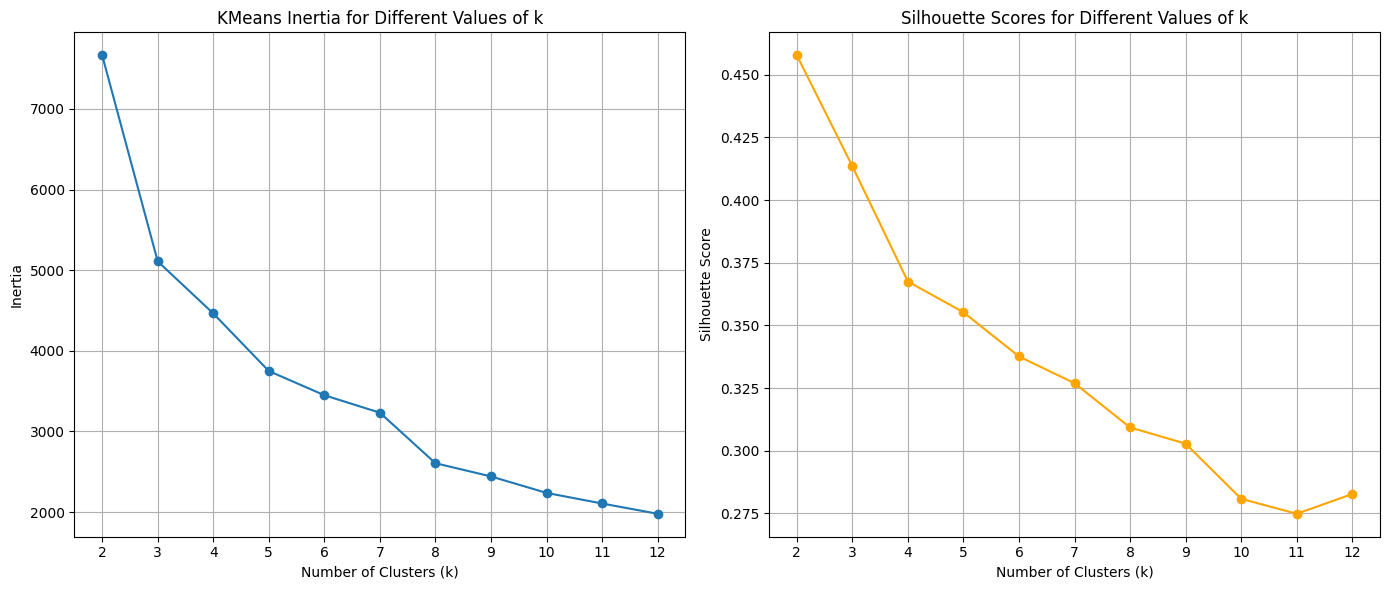

In [1000]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

In [1001]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=300, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data_df)
cluster_labels

array([0, 2, 3, ..., 3, 0, 2], shape=(4106,), dtype=int32)

In [1002]:
non_outliers_df["Cluster"] = cluster_labels

non_outliers_df

,Customer ID,MonetaryValue,Frequency,Recency,Tenure,Cluster
0,12346,5.14,1.10,5.11,4.78,0
1,12347,7.19,1.10,1.10,3.64,2
2,12348,5.40,0.69,4.30,0.00,3
3,12349,7.71,1.10,3.76,5.20,0
4,12351,5.71,0.69,2.40,0.00,3
...,...,...,...,...,...,...
4280,18283,6.43,1.95,2.89,5.62,2
4281,18284,6.02,0.69,4.20,0.00,3
4282,18285,5.93,0.69,5.69,0.00,3
4283,18286,7.13,1.10,4.72,5.51,0


In [1003]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=300, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data_df)

In [1004]:
cluster_colors = {0: '#1f77b4', 
                  1: '#ff7f0e', 
                  2: '#2ca02c', 
                  3: '#d62728',
                  -1: '#9467bd', 
                  -2: '#8c564b', 
                  -3: '#e377c2'
                  }


cluster_labels_names = {0: 'RETAIN', 1: 'RE-ENGAGE', 2: 'NURTURE', 3: 'REWARD'}



In [1005]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(scaled_data_df)

pca_df = pd.DataFrame(pca_coords, columns=['PC1', 'PC2'], index=non_outliers_df.index)
pca_df['Cluster'] = non_outliers_df['Cluster']

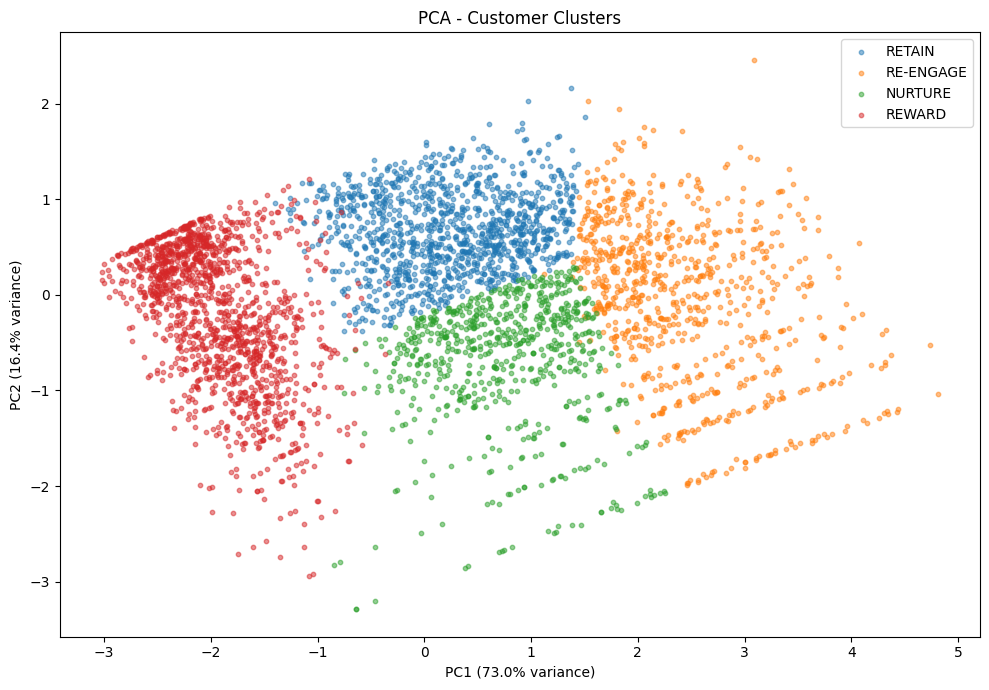

In [1006]:
plt.figure(figsize=(10, 7))
for cluster, color in {k: v for k, v in cluster_colors.items() if k >= 0}.items():
    mask = pca_df['Cluster'] == cluster
    plt.scatter(pca_df.loc[mask, 'PC1'], 
                pca_df.loc[mask, 'PC2'], 
                c=color,
                label=cluster_labels_names[cluster], 
                alpha=0.5, s=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('PCA - Customer Clusters')
plt.legend()

plt.tight_layout()
plt.show()

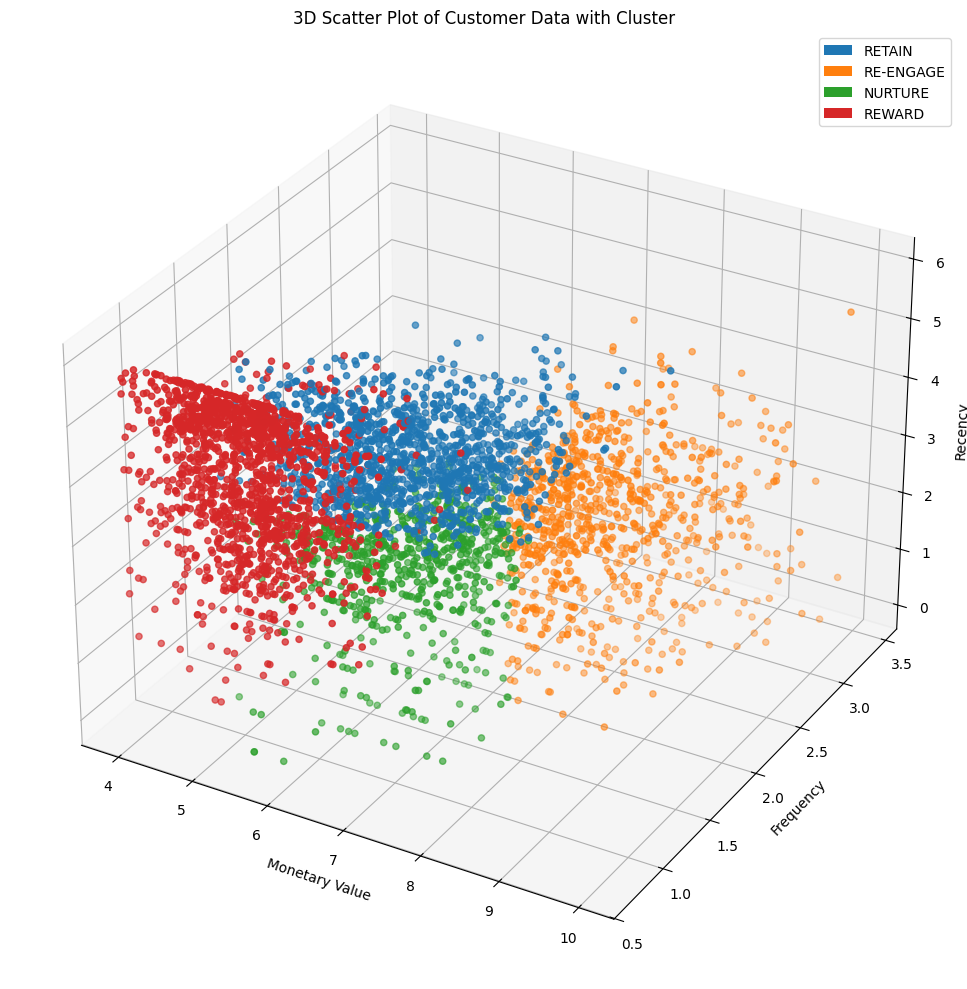

In [1007]:
colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'], 
                     non_outliers_df['Frequency'], 
                     non_outliers_df['Recency'],
                     c=colors,
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Customer Data with Cluster')
legend_elements = [Patch(facecolor=color, label=cluster_labels_names[cluster]) 
                   for cluster, color in cluster_colors.items() if cluster >= 0]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

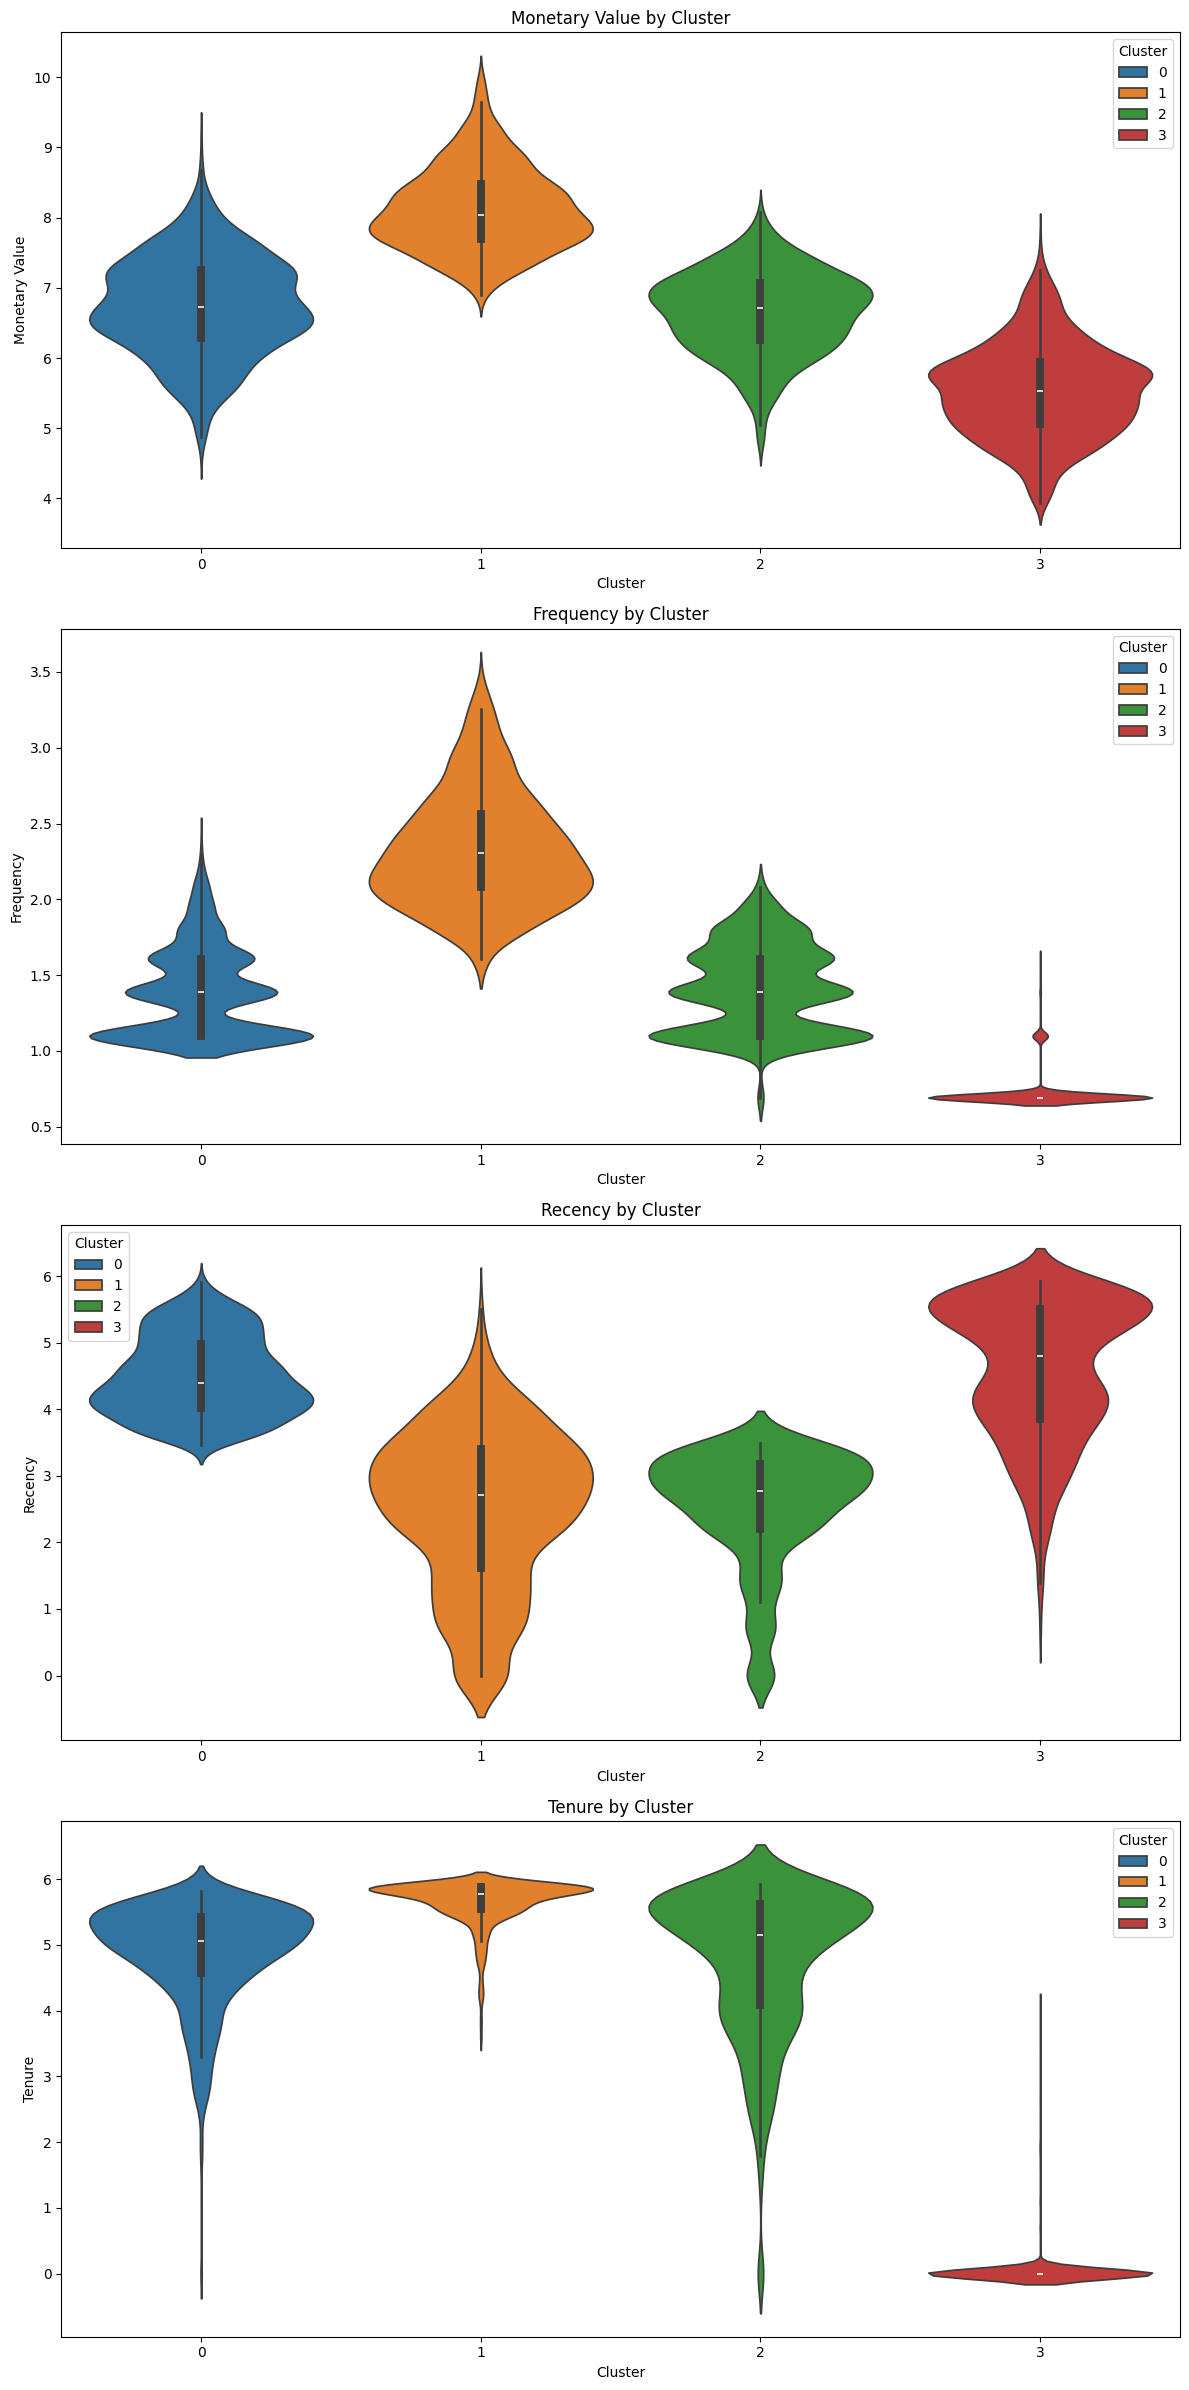

In [1008]:
plt.figure(figsize=(12, 24))


plt.subplot(4, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(4, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(4, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.subplot(4, 1, 4)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Tenure'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
plt.title('Tenure by Cluster')
plt.ylabel('Tenure')

handles = [Patch(facecolor=cluster_colors[c], label=cluster_labels_names[c]) 
           for c in cluster_colors if c >= 0]


plt.tight_layout()
plt.show()



In [1009]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]
recency_only_outliers = recency_outliers_df.drop(
    recency_outliers_df.index.intersection(monetary_outliers_df.index).union(
    recency_outliers_df.index.intersection(frequency_outliers_df.index))
)

tenure_only_outliers = tenure_outliers_df.drop(
    tenure_outliers_df.index.intersection(monetary_outliers_df.index).union(
    tenure_outliers_df.index.intersection(frequency_outliers_df.index)).union(
    tenure_outliers_df.index.intersection(recency_outliers_df.index))
)


monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3
recency_only_outliers["Cluster"] = -4
tenure_only_outliers["Cluster"] = -5

for df in [monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers, recency_only_outliers, tenure_only_outliers]:
    df.drop(columns=["AOV"], inplace=True)


outlier_clusters_df = pd.concat([monetary_only_outliers, 
                                  frequency_only_outliers, 
                                  monetary_and_frequency_outliers, 
                                  recency_only_outliers,
                                  tenure_only_outliers])

outlier_clusters_df

,Customer ID,MonetaryValue,Frequency,Recency,Tenure,Cluster
488,13081,10.34,3.00,1.95,5.89,-1
515,13112,3.07,0.69,5.18,0.00,-1
552,13163,2.93,0.69,5.51,0.00,-1
1000,13788,1.56,0.69,4.95,0.00,-1
1065,13881,10.24,3.18,2.40,5.60,-1
...,...,...,...,...,...,...
3718,17511,11.35,3.47,1.10,5.91,-3
3962,17841,10.29,4.52,0.00,5.92,-3
3969,17850,10.84,5.05,2.08,5.89,-3
4038,17949,10.84,4.30,1.95,5.91,-3


In [1010]:
print(len(recency_only_outliers))
print(len(tenure_only_outliers))

0
0


Every customer who is a recency or tenure outlier is also a monetary or frequency outlier. There are no customers who are purely recency or tenure outliers alone.
So keeping -4 and -5 adds nothing

In [1011]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]


monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3


for df in [monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers]:
    df.drop(columns=["AOV"], inplace=True)


outlier_clusters_df = pd.concat([monetary_only_outliers, 
                                  frequency_only_outliers, 
                                  monetary_and_frequency_outliers])

outlier_clusters_df

,Customer ID,MonetaryValue,Frequency,Recency,Tenure,Cluster
488,13081,10.34,3.00,1.95,5.89,-1
515,13112,3.07,0.69,5.18,0.00,-1
552,13163,2.93,0.69,5.51,0.00,-1
1000,13788,1.56,0.69,4.95,0.00,-1
1065,13881,10.24,3.18,2.40,5.60,-1
...,...,...,...,...,...,...
3718,17511,11.35,3.47,1.10,5.91,-3
3962,17841,10.29,4.52,0.00,5.92,-3
3969,17850,10.84,5.05,2.08,5.89,-3
4038,17949,10.84,4.30,1.95,5.91,-3


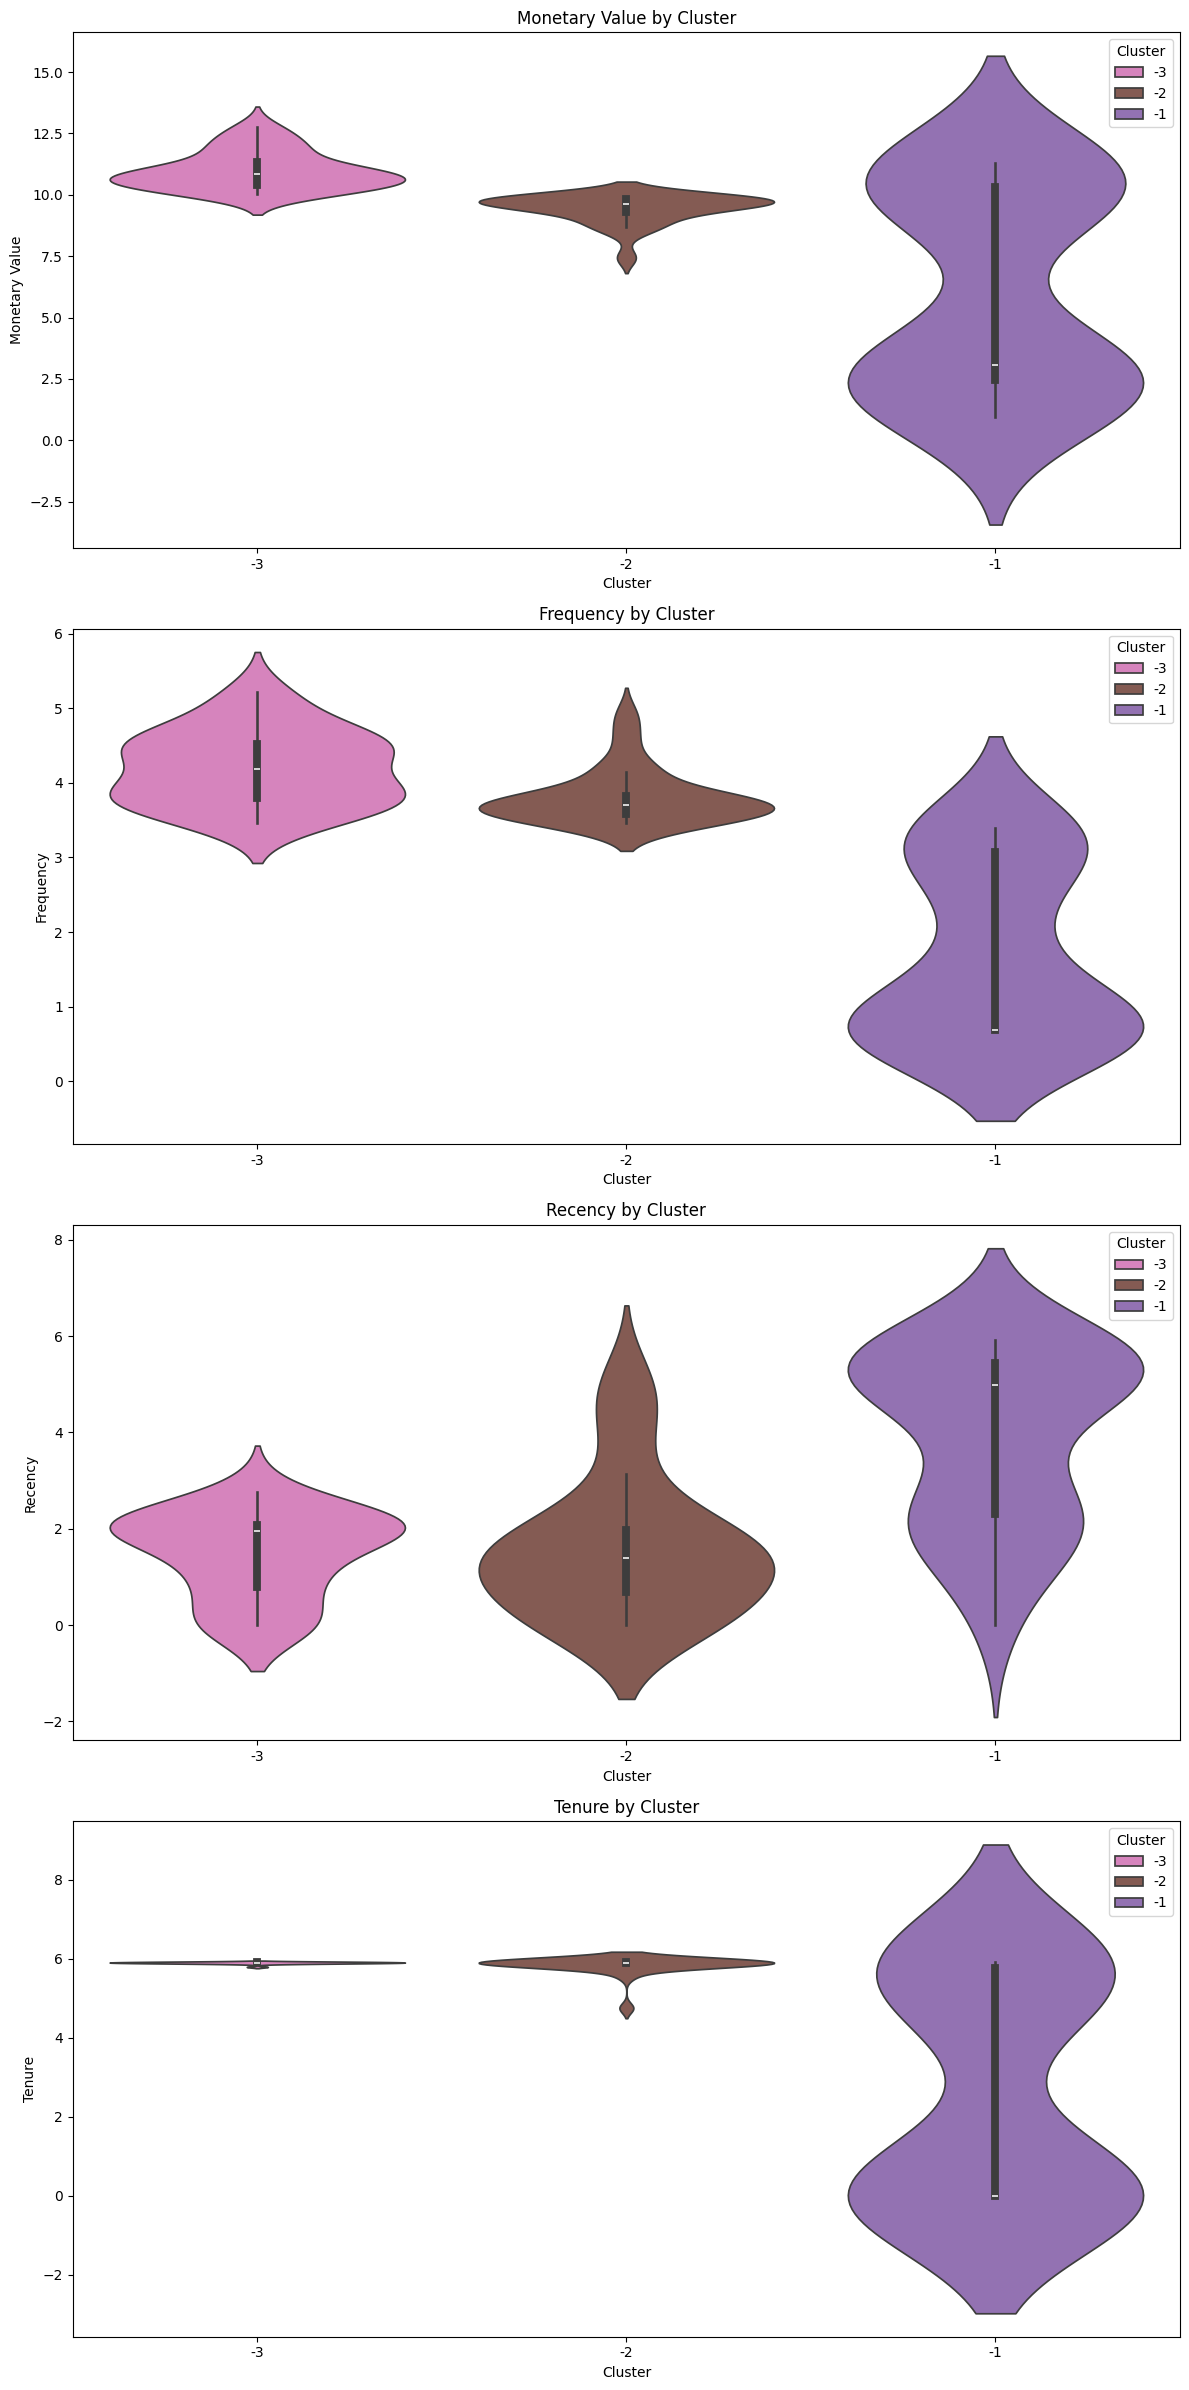

In [1012]:
plt.figure(figsize=(12, 24))

plt.subplot(4, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(4, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(4, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.subplot(4, 1, 4)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Tenure'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
plt.title('Tenure by Cluster')
plt.ylabel('Tenure')


plt.tight_layout()
plt.show()

In [1013]:
cluster_labels = {
    0: "RETAIN",
    1: "RE-ENGAGE",
    2: "NURTURE",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT",
}



In [1014]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df



,Customer ID,MonetaryValue,Frequency,Recency,Tenure,Cluster
0,12346,5.14,1.10,5.11,4.78,0
1,12347,7.19,1.10,1.10,3.64,2
2,12348,5.40,0.69,4.30,0.00,3
3,12349,7.71,1.10,3.76,5.20,0
4,12351,5.71,0.69,2.40,0.00,3
...,...,...,...,...,...,...
3718,17511,11.35,3.47,1.10,5.91,-3
3962,17841,10.29,4.52,0.00,5.92,-3
3969,17850,10.84,5.05,2.08,5.89,-3
4038,17949,10.84,4.30,1.95,5.91,-3


In [1015]:
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df



,Customer ID,MonetaryValue,Frequency,Recency,Tenure,Cluster,ClusterLabel
0,12346,5.14,1.10,5.11,4.78,0,RETAIN
1,12347,7.19,1.10,1.10,3.64,2,NURTURE
2,12348,5.40,0.69,4.30,0.00,3,REWARD
3,12349,7.71,1.10,3.76,5.20,0,RETAIN
4,12351,5.71,0.69,2.40,0.00,3,REWARD
...,...,...,...,...,...,...,...
3718,17511,11.35,3.47,1.10,5.91,-3,DELIGHT
3962,17841,10.29,4.52,0.00,5.92,-3,DELIGHT
3969,17850,10.84,5.05,2.08,5.89,-3,DELIGHT
4038,17949,10.84,4.30,1.95,5.91,-3,DELIGHT


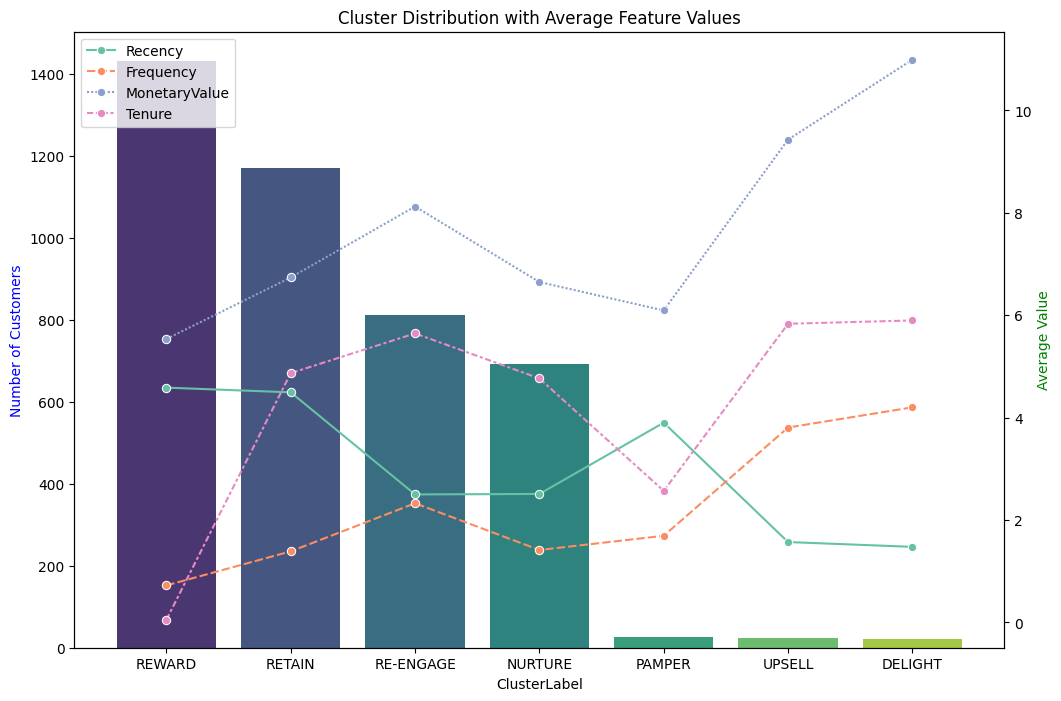

In [1017]:
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()

feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 
                                                            'Frequency', 
                                                            'MonetaryValue', 
                                                            'Tenure']].mean()

feature_means = feature_means.reindex(cluster_counts.index)

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()


sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()



In [1018]:
print(feature_means)

              Recency  Frequency  MonetaryValue  Tenure
ClusterLabel                                           
REWARD           4.59       0.72           5.54    0.05
RETAIN           4.49       1.39           6.74    4.87
RE-ENGAGE        2.50       2.33           8.12    5.65
NURTURE          2.51       1.41           6.65    4.77
PAMPER           3.90       1.69           6.09    2.57
UPSELL           1.57       3.81           9.43    5.83
DELIGHT          1.48       4.20          10.99    5.90
